<a href="https://colab.research.google.com/github/hoeen/kaggle/blob/main/ai08_project4_%EB%B0%95%EC%9A%B0%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codestates AI Project 4. Deep Learning

# 2D-CNN 을 이용한 암호화폐 예측

- Kaggle competition [G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting) 에 참여하여 암호화폐의 변동성 예측 
- 모델 선정 : 2D CNN
    - Time-series 데이터의 예측 문제에서 이전부터 RNN, LSTM 등이 이용되어 왔지만, 여러 논문 search 결과 CNN 또한 기존의 이미지 문제에서뿐만 아니라 시계열 예측에도 좋은 성능을 보인다는 결과가 나왔다.   
    (관련 논문:[https://www.sciencedirect.com/science/article/pii/S1877050918307828])
    - CNN 모델의 마지막 layer을 sigmoid 등을 이용한 classification이 아닌 Regression으로 바꾸어 적용할 수 있다. 

## Kaggle competition data 다운로드

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [2]:
!kaggle competitions download -c g-research-crypto-forecasting

  0% 0.00/59.0 [00:00<?, ?B/s]
100% 59.0/59.0 [00:00<00:00, 122kB/s]
  0% 0.00/660k [00:00<?, ?B/s]
100% 660k/660k [00:00<00:00, 44.1MB/s]
 99% 1.01G/1.02G [00:24<00:00, 44.7MB/s]
100% 1.02G/1.02G [00:25<00:00, 43.7MB/s]
 94% 89.0M/94.2M [00:02<00:00, 30.5MB/s]
100% 94.2M/94.2M [00:02<00:00, 36.3MB/s]
  0% 0.00/406 [00:00<?, ?B/s]
100% 406/406 [00:00<00:00, 420kB/s]
  0% 0.00/5.78k [00:00<?, ?B/s]
100% 5.78k/5.78k [00:00<00:00, 5.72MB/s]
  0% 0.00/444 [00:00<?, ?B/s]
100% 444/444 [00:00<00:00, 465kB/s]


In [4]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
# import packages
from tensorflow.keras import layers
from IPython import display

import glob
import imageio
import os
import PIL
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd



import random
 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

In [ ]:
# train data - before 2021-06-13

def read_csv_strict(file_name='train.csv'):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['datetime'] < '2021-06-13 00:00:00']
    return df



def read_test_csv(file_name='train.csv'):
    df = pd.read_csv(file_name)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['datetime'] >= '2021-06-13 00:00:00']
    return df


train_df = read_csv_strict()
test_df = read_test_csv()

In [26]:
train_df.head(5)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,2018-01-01 00:01:00
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2018-01-01 00:01:00


## 데이터 살펴보기

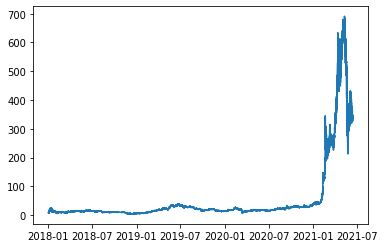

In [ ]:
# 암호화폐 종류에 따라 나누어 리스트에 담기
data_list = list()

for i in range(max(train_df.Asset_ID)):
    data_list.append(train_df[train_df.Asset_ID == i].set_index('datetime'))


plt.plot(data_list[0].index, data_list[0].Open)

In [ ]:
def plot_crypto(number:int, y:str, x=None, ax=None, **plt_kwargs):
    # call crypto name
    name = pd.read_csv('asset_details.csv').loc[number, 'Asset_Name']
    if ax is None:
        ax = plt.gca()
    
    if x is not None: 
        ax.plot(data_list[number][x], data_list[number][y], **plt_kwargs)
        plt.close()
    else:
        ax.plot(data_list[number].index, data_list[number][y], **plt_kwargs)
        plt.close()
        
    ax.set_title(str(number)+' : '+name)
    # ax.set_xticks(['2018','2019','2020','2021'])
    ax.tick_params(axis='x', rotation=45)
    return ax

def plot_all(y:str, x=None):
    fig, ax = plt.subplots(3,5, figsize=(15,10))
    if x:
        plt.suptitle(f'{x} vs {y}')
    else:
        plt.suptitle(f'timestamp vs {y}')
    row, col = (0,0)
    for i in range(13):
        plot_crypto(i, y, x, ax = ax[row,col])
        if col < 4:
            col += 1
        else:
            row += 1
            col = 0

    plt.tight_layout()
    return fig



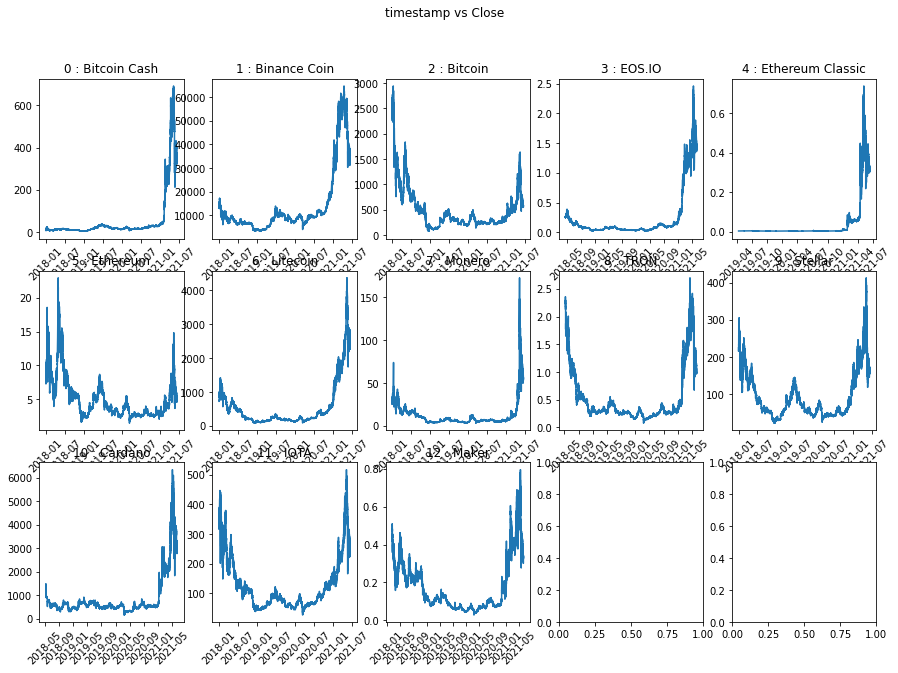

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_all('Close')

## 데이터 전처리

In [27]:
# 데이터 전처리
from sklearn.preprocessing import StandardScaler

def preprocess_data(train_df, number):
    
    # id에 맞는 데이터 불러오기
    bitc = train_df[train_df.Asset_ID == number].set_index('timestamp')

    # 무한대, 무한소 nan으로 치환 
    bitc = bitc.replace([np.inf, -np.inf], np.nan)

    # 이미 존재하는 결측치는 제거
    bitc = bitc.dropna()

    
    # 처음과 끝 시간 사이에 60초 간격으로 range 생성
    bitc_fill_range = range(bitc.index[0], bitc.index[-1]+60, 60)
    
    # 새로운 60초 간격의 range에 맞게 padding하여 데이터프레임 생성
    bitc = bitc.reindex(bitc_fill_range, method='pad') 
    
    # datetime 으로 다시 인덱스 재설정
    bitc['datetime'] = pd.to_datetime(bitc.index, unit='s')
    bitc = bitc.set_index('datetime') 
    
    # scale the data
    scaler = StandardScaler()

    features = bitc.columns.drop('Target')
    bitc_scaled_X = scaler.fit_transform(bitc[features])

    bitc_scaled_X_with_y = pd.concat([pd.DataFrame(bitc_scaled_X, columns=features),
                                            bitc['Target'].reset_index(drop=True)], axis=1)
                                        

    return bitc_scaled_X_with_y



data_prep = []
asset_list_df = pd.read_csv('asset_details.csv')

for i in range(asset_list_df.Asset_ID.max()):
    print(f'{i} preprocessing...')
    data_prep.append(preprocess_data(train_df, i))
    
data_prep[0].head(5)

0 preprocessing...
1 preprocessing...
2 preprocessing...
3 preprocessing...
4 preprocessing...
5 preprocessing...
6 preprocessing...
7 preprocessing...
8 preprocessing...
9 preprocessing...
10 preprocessing...
11 preprocessing...
12 preprocessing...


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,0.0,-0.370668,-0.384969,-0.385015,-0.384921,-0.384974,-0.617670,-0.384964,-0.014399
1,0.0,-0.366007,-0.384969,-0.385015,-0.385054,-0.385106,-0.620022,-0.385048,-0.015875
2,0.0,-0.277450,-0.385170,-0.385015,-0.385309,-0.385361,-0.123516,-0.385209,-0.015410
3,0.0,-0.349694,-0.385218,-0.385215,-0.385398,-0.385223,-0.601712,-0.385394,-0.012524
4,0.0,-0.370668,-0.385220,-0.385265,-0.385556,-0.385608,-0.601978,-0.385577,-0.005940


## Build Model - use CNN

following tutorial of ['Using CNN for financial time series prediction'](https://machinelearningmastery.com/using-cnn-for-financial-time-series-prediction/)

### data generator : 한달 기간의 3/4 : train set ,  1/4 : validate set 으로 순서대로 나눈 batch를 구성.

### train set 기간 안에서 랜덤한 날짜의 batch를 불러와 모델을 학습시킨다.  

In [7]:
def datagen(data, seq_len, batch_size, targetcol, kind):
    batch = []
    while True:
        df = random.choice(data)
        df = pd.DataFrame(df, 
                          columns=['Asset_ID', 'Count', 'Open', 
                                   'High', 'Low', 'Close',
                                   'Volume', 'VWAP', 'Target'])
        df = df.drop(columns=['Asset_ID'])  # drop Asset_ID
        input_cols = [c for c in df.columns if c != targetcol]
        index = df.index
        split = int(len(index)*TRAIN_VALID_RATIO)
        if kind == 'train':
            index = index[:split]
        elif kind == 'valid':
            index = index[split:]
            
        while True:
            t = random.choice(index)
            n = (df.index == t).argmax()
            if n-seq_len+1 < 0:
                continue # seq_len보다 n이 크지 않으면 다시 choice
            frame = df.iloc[n-seq_len+1:n+1]
            batch.append([frame[input_cols].values, df.loc[t, targetcol]])
            break
        
        if len(batch) == batch_size:
            X, y = zip(*batch)
            X, y = np.expand_dims(np.array(X), 3), np.array(y)
            yield X, y
            batch = []

In [8]:
# 2D CNN model

seq_len = 60*24*30 #한달
def cnnpred_2d(seq_len=seq_len, n_features=7, n_filters=8):
    
    model = Sequential([
        Conv2D(n_filters, kernel_size=(1, n_features), activation='relu', 
               padding='same', input_shape=(seq_len, n_features, 1)),
        # Conv2D(n_filters, kernel_size=(60*24,1), activation='relu'),
        MaxPool2D(pool_size=(2,1)),
        # Conv2D(n_filters, kernel_size=(60,1), activation='relu'),
        # MaxPool2D(pool_size=(2,1)),
        Flatten(),
        Dense(100),
        Dense(10),
        # Dropout(droprate),
        Dense(1, activation='linear')
    ])
    return model

cnnpred_2d().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 43200, 7, 8)       64        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21600, 7, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1209600)           0         
                                                                 
 dense (Dense)               (None, 100)               120960100 
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                        

In [9]:
seq_len = 30*24*60  # 한달
batch_size = 16
n_epochs = 10
n_features = 7
TRAIN_VALID_RATIO = 0.75

model = cnnpred_2d(seq_len, n_features, n_filters=8)
model.compile(optimizer='adam', loss='mse')
model.fit(datagen(data_prep, seq_len, batch_size, "Target", "train"),
         validation_data = datagen(data_prep, seq_len, batch_size, "Target", "valid"),
          epochs = n_epochs,
          validation_steps=10, steps_per_epoch=30,
          verbose=1, #callbacks = callbacks
         )

Epoch 1/10
30/30 [==============================] - 71s 2s/step - loss: 732658.5625 - val_loss: 4116498.7500
Epoch 2/10
30/30 [==============================] - 63s 2s/step - loss: 88625.3281 - val_loss: 320412.6875
Epoch 3/10
30/30 [==============================] - 65s 2s/step - loss: 20493.1836 - val_loss: 21491.2617
Epoch 4/10
30/30 [==============================] - 65s 2s/step - loss: 3259.0093 - val_loss: 50577.1562
Epoch 5/10
30/30 [==============================] - 66s 2s/step - loss: 1382.0055 - val_loss: 59437.1641
Epoch 6/10
30/30 [==============================] - 66s 2s/step - loss: 962.1733 - val_loss: 55760.6172
Epoch 7/10
30/30 [==============================] - 64s 2s/step - loss: 497.3737 - val_loss: 34439.6797
Epoch 8/10
30/30 [==============================] - 67s 2s/step - loss: 272.9270 - val_loss: 18609.2617
Epoch 9/10
30/30 [==============================] - 70s 2s/step - loss: 297.8791 - val_loss: 5445.0674
Epoch 10/10
30/30 [==============================] - 

In [10]:
# save model 
# model.save('cnn2d_5epoch')
model.save('cnn2d_10epoch_30steps')

INFO:tensorflow:Assets written to: cnn2d_10epoch_30steps/assets


## Test the model - Bitcoin 에 적용

In [21]:
# model = tf.keras.models.load_model('cnn2d_5epoch')


# test trained data on Bitcoin : 2
btc_test, btc_test_date = preprocess_data(test_df, 2)


In [22]:
def testgen(data, seq_len, targetcol):
    batch = []
    df = data.drop(columns=['Asset_ID'])  # drop Asset_ID
    input_cols = [c for c in df.columns if c != targetcol]
    index = df.index
    for i in range(seq_len, seq_len+1000):
        frame = df.iloc[i-seq_len:i]
        batch.append([frame[input_cols].values, frame[targetcol].values[-1]])
    X, y = zip(*batch)
    return np.expand_dims(np.array(X), 3), np.array(y)
           
       





In [23]:
seq_len = 60*24*30
test_X, test_y = testgen(btc_test, seq_len, 'Target')

In [24]:
y_pred = model.predict(test_X)

## 예측값 시각화 - 16분 동안의 변동성 예측

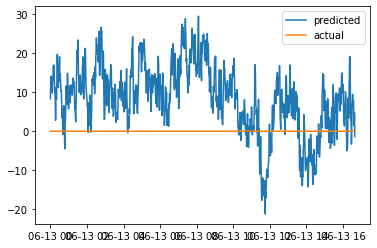

In [25]:
plt.plot(btc_test_date[:1000], y_pred, label='predicted')
plt.plot(btc_test_date[:1000], test_y[:1000], label='actual')
plt.legend()

## 결론. 한계점 및 추후 발전 방향
- CNN을 이용하여 암호화폐 예측모델을 구성하였고 훈련시키는 데 성공하였다.
- 충분치 못한 epoch 그리고 단순한 모델 구조로 인해 정확한 prediction에는 실패.
- 암호화폐의 변동성에 대한 여러 원인에 대한 파악 불가.
- Epoch을 늘리고 모델을 좀더 복잡한 layer로 구성하면 더 좋은 결과를 낼 수 있을 것이다.
- LSTM 등 다른 모델과의 성능 비교 또한 필요함. Ensemble을 이용하여 성능을 좀더 발전시킬 수 있을 것.